# Predicting Power Usage Needs for the city of Los Angeles, California

### M. J. Madsen

This notebook develops and tests machine learning algorithms for predicting power usage for the upcoming month.

In [1]:
## Library Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from time import time
from matplotlib.ticker import FuncFormatter
import xgboost
import seaborn as sns
%matplotlib inline
sns.set_style("white")

I previously aggregated data from four sources ("/src/LA_Utility_Data_Enrichment.ipynb"). I'm starting with the joined dataset.

In [3]:
dfv7 = pd.read_csv("../data/enriched_data.csv",parse_dates=[2])
dfv7.head()

,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND,Nreturns,AGI,SW,EIC,AWND,CLDD,HTDD,PRCP,TAVG
0,16.70,396,2008-03-01,90230,0.277616,3,2008,31766,11785759,11672688,15572,1008925,765127.0,3537.0,3.2,6.7,91.5,0.8,15.6
1,30.18,970,2008-03-01,90272,0.173857,3,2008,22986,60557886,59133992,11165,3569670,1750980.0,355.0,3.2,6.7,91.5,0.8,15.6
2,27.64,472,2008-03-01,91607,0.193408,3,2008,27927,6376445,6318261,14046,814778,611688.0,2643.0,3.2,6.7,91.5,0.8,15.6
3,56.26,247,2008-03-01,90013,0.026889,3,2008,11772,1773762,1737681,3186,224173,115494.0,589.0,3.2,6.7,91.5,0.8,15.6
4,23.97,331,2008-03-01,90061,0.221657,3,2008,26872,6896569,6895207,10076,274753,238903.0,9757.0,3.2,6.7,91.5,0.8,15.6


I will be splitting the data into two time-based pieces: historical data that will be used for training the model, and "future" data that will be used to test the model predictions. The dates and number of months included in the data set are:

In [4]:
print(dfv7['Date'].min())
print(dfv7['Date'].max())
print(len(dfv7['Zip'].unique()))

2005-07-01 00:00:00
2013-06-01 00:00:00
134


I will be predicting the power needs: first I'll do some specific data exploration: what does the annual power use pattern look like?

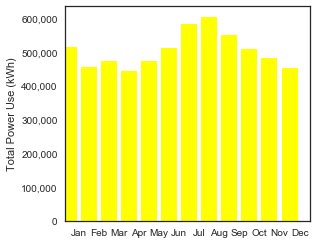

In [5]:

groups = dfv7.groupby('Month')[['Water Use','Power Use']].sum()
data = groups.reset_index()


# Power Use
plt.figure(figsize=(4.5,3.5))
plt.bar(data['Month'],data['Power Use'], color='yellow')
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep' ,'Oct' ,'Nov' ,'Dec']
plt.xlim(0.8,13)
plt.xticks(np.arange(1.5,len(xlabels)+1))
ax = plt.gca()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(xlabels)
plt.ylabel('Total Power Use (kWh)')
plt.tight_layout()
plt.gcf().savefig('../docs/Power Use.png', dpi=300)

## Cleaning the power data

The next step is to clean the data - there are a number of problem areas in the dataset.

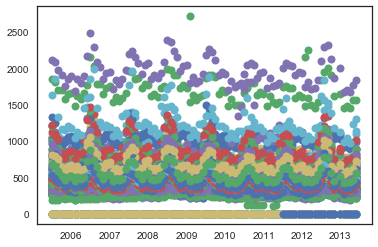

In [7]:
# Group data by zip code
groups = dfv7.groupby('Zip')

plt.figure()
ax1=plt.gca()
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax1.plot(group['Date'], group['Power Use'], marker='o', linestyle='', ms=8, label=name)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))


I cut any power use zip codes that have zeros in them - these areas don't have complete data for whatever reason.

In [8]:
outliers_2 = dfv7[dfv7['Power Use'] == 0]
outlierzips = outliers_2['Zip'].unique()

dfv7_power = pd.DataFrame(dfv7[~dfv7['Zip'].isin(outlierzips)])

print("Rows removed: {}".format((len(dfv7)-len(dfv7_power))))
dfv7_power.sort_values(['Zip','Date'],inplace=True)

Rows removed: 950


I'm double checking the data to make sure it looks more uniform (without those outliers).

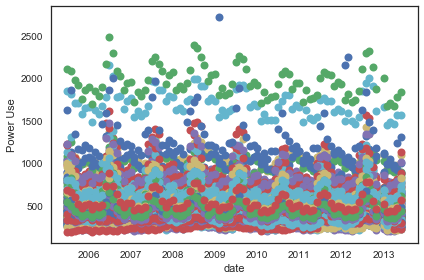

In [11]:
groups = dfv7_power.groupby('Zip')
plt.figure()
ax2 = plt.gca()
ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax2.plot(group['Date'], group['Power Use'], marker='o', linestyle='', ms=8)


plt.xlabel('date')
ax2.set_ylabel('Power Use')
plt.tight_layout()

## Prior Use Features

Because of the periodic nature of the data, I add in two more features: the prior year (For a give month) and the running average (for that month, for that zip-code).

I will add in the prior year's number as a feature. For the first year, I will round the current year as an estimate.

In [12]:
# Get the columns we'll need to get the offset
dfoffset = dfv7_power[['Date','Month','Year','Zip','Power Use']].reset_index()

# Offset the columns
dfoffset['Prior Year'] = dfoffset['Year'].apply(lambda year: year - 1)

# Merge them back together again
df_new = dfoffset.merge(dfoffset[['Year','Month','Zip','Power Use']], how='left',left_on=['Prior Year', 'Month','Zip'], right_on=['Year','Month','Zip'],suffixes=['','_Prior'])
df_new.sort_values(['Zip','Month','Year'],inplace=True)

# Fill in the missing values with a rounded current year value
df_new['Power Use_Prior'].fillna(value=df_new['Power Use'].round(),inplace=True)
df_new.set_index('index',inplace=True)
df_new.index.name = None

dfv8 = pd.DataFrame(dfv7_power)
dfv8.sort_values(['Zip','Month','Year'],inplace=True)
dfv8['Power Use Prior Year'] = df_new['Power Use_Prior']
dfv8.head(5)

,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND,Nreturns,AGI,SW,EIC,AWND,CLDD,HTDD,PRCP,TAVG,Power Use Prior Year
5099,19.61,362,2006-01-01,90001,0.255217,1,2006,57110,9071361,9071361,17605,432481,380549.0,16030.0,3.1,5.8,124.6,36.1,14.5,362.0
8025,19.43,378,2007-01-01,90001,0.256603,1,2007,57110,9071361,9071361,19925,466651,411527.0,17682.0,2.5,3.0,184.2,9.9,12.5,362.0
577,17.86,378,2008-01-01,90001,0.268687,1,2008,57110,9071361,9071361,18561,467773,421709.0,18650.0,3.2,0.8,158.0,118.5,13.3,378.0
11217,17.05,362,2009-01-01,90001,0.274922,1,2009,57110,9071361,9071361,19666,477815,418527.0,22416.0,2.0,16.5,101.2,13.0,15.6,378.0
6828,13.69,377,2010-01-01,90001,0.300785,1,2010,57110,9071361,9071361,20342,492447,421322.0,22522.0,2.7,1.4,114.7,109.3,14.7,362.0


Next, add in the cumulative average for the Prior Year Use

In [13]:
zipgroups = dfv8[['Power Use Prior Year','Date','Month','Year','Zip']].groupby(['Zip','Month'])

dfv8['Power Use Cum Avg']=zipgroups['Power Use Prior Year'].expanding().mean().reset_index().set_index('level_2')['Power Use Prior Year']
dfv8.head(2)

,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND,...,AGI,SW,EIC,AWND,CLDD,HTDD,PRCP,TAVG,Power Use Prior Year,Power Use Cum Avg
5099,19.61,362,2006-01-01,90001,0.255217,1,2006,57110,9071361,9071361,...,432481,380549.0,16030.0,3.1,5.8,124.6,36.1,14.5,362.0,362.0
8025,19.43,378,2007-01-01,90001,0.256603,1,2007,57110,9071361,9071361,...,466651,411527.0,17682.0,2.5,3.0,184.2,9.9,12.5,362.0,362.0


## Prior Month Use Features

Now I add in a feature that takes in the last month's usage and a feature that averages the last 3 months' usage


In [14]:
# Get the columns we'll need to get the offset
dfoffset = dfv7_power[['Date','Zip','Power Use']].reset_index()

# Offset the columns
dfoffset['Prior Month'] = dfoffset['Date'] - pd.offsets.MonthEnd() - pd.offsets.MonthBegin()

# Merge them back together again
df_new = dfoffset.merge(dfoffset[['Date','Zip','Power Use']], how='left',left_on=['Prior Month','Zip'], right_on=['Date','Zip'],suffixes=['','_PriorMonth'])
df_new.sort_values(['Zip','Date'],inplace=True)

# Fill in the missing values with a rounded current month value
df_new['Power Use_PriorMonth'].fillna(value=df_new['Power Use'].round(),inplace=True)
df_new.set_index('index',inplace=True)
df_new.index.name = None

dfv8.sort_values(['Zip','Date'],inplace=True)
dfv8['Power Use Prior Month'] = df_new['Power Use_PriorMonth']


# Add in a 3-month prior average for each zip
zipgroups = dfv8[['Power Use Prior Month','Date','Zip']].groupby(['Zip'])

dfv8['Power Use Rolling Month']=zipgroups['Power Use Prior Month'].rolling(3, min_periods=1).mean().reset_index().set_index('level_1')['Power Use Prior Month']
dfv8.head(2)

,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND,...,EIC,AWND,CLDD,HTDD,PRCP,TAVG,Power Use Prior Year,Power Use Cum Avg,Power Use Prior Month,Power Use Rolling Month
2173,21.52,329,2005-07-01,90001,0.240515,7,2005,57110,9071361,9071361,...,16162.0,3.5,65.1,2.5,0.0,20.4,329.0,329.0,329.0,329.0
1774,22.42,340,2005-08-01,90001,0.233588,8,2005,57110,9071361,9071361,...,16162.0,3.5,79.2,0.0,0.0,20.9,340.0,340.0,329.0,329.0


Finally, I can drop the two columns I don't need from the dataset.

In [21]:
dfv9= dfv8.drop(['Water Use','M_dist'],axis=1)

## Data test/training split

I first split off the last 12 months' data from the set - I want to be able to show that my predictions work for that data. It will serve as my out-of-sample dataset.

I'll visulaize this as a solid line for the training data and a dashed line for the testing data.

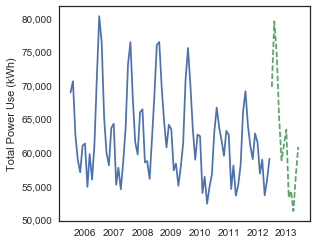

In [26]:
df_train = dfv9[dfv9['Date'] <= '2012-06-01']
df_test = dfv9[dfv9['Date'] > '2012-06-01']

train_grouped = df_train.groupby('Date')['Power Use'].sum()
train_data = train_grouped.reset_index()

test_grouped = df_test.groupby('Date')['Power Use'].sum()
test_data = test_grouped.reset_index()

plt.figure(figsize=(4.5,3.5))
plt.plot(train_data['Date'],train_data['Power Use'])
plt.plot(test_data['Date'],test_data['Power Use'],linestyle='--')
#plt.xlim(data1['Date'].min(), dfv7['Date'].max() - pd.tseries.offsets.DateOffset(years=1))
ax = plt.gca()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total Power Use (kWh)')
plt.tight_layout()
plt.gcf().savefig('../docs/Power Use_time.png', dpi=300)

I need to turn the data into numeric features and drop the unneeded date column before I can test models.

In [27]:

test_features = df_test.drop(['Date'],axis=1).ix[:,1:]
test_target = df_test.ix[:,0]
print("{0} test rows from {1} months".format(len(test_target),len(df_test['Date'].unique())))


train_features = df_train.drop(['Date'],axis=1).ix[:,1:]
train_target = df_train.ix[:,0]
print("{0} test rows from {1} months".format(len(train_target),len(df_train['Date'].unique())))

1353 test rows from 11 months
10332 test rows from 84 months


# Model Testing

## Prior Year Model

My first model is to simply use the "prior year" data in order to predict the usage for each location.

My first metric is to gauge how far off the prediction for each location (for each month) is.

The second metric is how far off the total prediction (for each month) is.

Total Actuals: 687476
Total Predictions: 665105.0
Total Absolute Prediction Error: 51,803 kWh (7.535244866729893%)
Total Net Prediction Error: -22,371 kWh (-3.2540772332415964%)


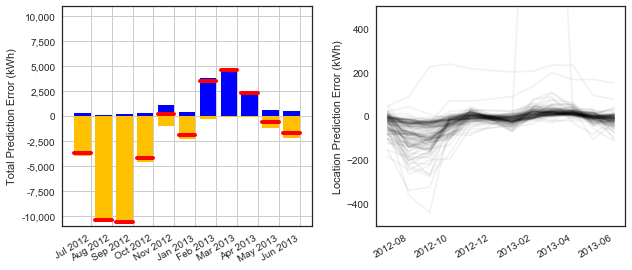

In [32]:
def measureModel(predictions, actuals, df_test):
    
    resultsdf = pd.DataFrame(df_test[['Date','Zip']])
    resultsdf['Predictions'] = predictions
    resultsdf['Actuals'] = actuals
    resultsdf['Error'] = predictions - actuals
    resultsdf['ABS Error'] = np.abs(resultsdf['Error'])
    print("Total Actuals: {}".format(actuals.sum()))
    print("Total Predictions: {}".format(predictions.sum()))
    resultsdf.sort_values(['Zip','Date'],inplace=True)
    groups = resultsdf.groupby('Zip')
    
    dateTotals = resultsdf.groupby('Date')['Error'].sum().reset_index()

    dateTotals['Total ABS Error'] = (resultsdf.groupby('Date')['ABS Error'].sum()).reset_index()['ABS Error']
    totalerror = dateTotals['Total ABS Error'].sum()
    #print("Total ABS Error: {:0.0f}".format(totalerror))
    
    
    f, (ax2, ax1) = plt.subplots(1, 2,figsize=(9,4))
    
    print('Total Absolute Prediction Error: {0:s} kWh ({1}%)'.format(format(int(totalerror), ','), totalerror/actuals.sum()*100))
    ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    # The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
    for name, group in groups:
        ax1.plot(group['Date'], group['Error'],color='black',alpha=0.05)
        #ax.set_aspect(1)
        #break
    #ax.legend(bbox_to_anchor=(1,0.5))
    ax1.set_ylabel('Location Prediction Error (kWh)')
    ax1.set_ylim(-500,500)
  
    
    
    positiveErrors = resultsdf[resultsdf['Error'] >= 0]
    negativeErrors = resultsdf[resultsdf['Error'] < 0]
    
    dateTotals['Total Positive Error'] = positiveErrors.groupby('Date')['Error'].sum().reset_index()['Error']
    dateTotals['Total Negative Error'] = negativeErrors.groupby('Date')['Error'].sum().reset_index()['Error']
    
    dateTotals['positive'] = dateTotals['Error'] > 0
    index = np.arange(0,len(dateTotals.index))
    barwidth = 0.8
    
    ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax2.bar(index,dateTotals['Total Positive Error'],barwidth, color='blue' )
    ax2.bar(index,dateTotals['Total Negative Error'],barwidth, color='#ffc000' )
    ax2.set_xticks(index+barwidth/2)
    ax2.set_xticklabels(dateTotals['Date'].apply(lambda x: x.strftime("%b %Y")))
    ax2.set_ylabel('Total Prediction Error (kWh)')
    ax2.set_ylim(-11000,11000)
    
    totalNeterror = dateTotals['Error'].sum()
    
    for entry in range(len(dateTotals)):
        ax2.plot([index[entry]-barwidth/2,index[entry]+barwidth/2],[dateTotals['Error'][entry],dateTotals['Error'][entry]],color='red',linewidth=4)
    
    #ax2.text(0,9500,'Net Prediction Error (kWh)',color='red',bbox=dict(facecolor='white', alpha=0.5))
    print('Total Net Prediction Error: {0:s} kWh ({1}%)'.format(format(int(totalNeterror), ','),totalNeterror/actuals.sum()*100))
    ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.grid()
    
    f.tight_layout()
    f.autofmt_xdate()
    
    return f
    
fig = measureModel(test_features['Power Use Prior Year'], test_target, df_test)
fig.savefig('../docs/LYModel_power.png', dpi=300)

## Simple Linear Model using base dataset features

RMS Error: 53.272 for LinearRegression
Fit Time: 0.037110090255737305 seconds
Predict Time: 0.0 seconds


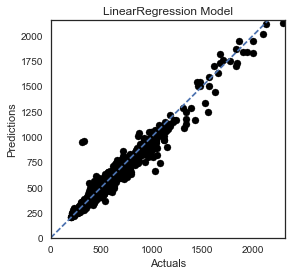

In [33]:
def fitAndPlot(train_features, test_features, train_target, test_target, model, **extraArgs):

    # Create linear regression objects for water and power
    fitmodel= model(**extraArgs)
        
    # Timing
    start = time()
    # Fit the data
    fitmodel.fit(train_features,train_target)
    fit_time = time() - start
    
    start = time()
    # Get the predictions
    predictions = fitmodel.predict(test_features)
    predict_time = time() - start

    # Plot the actuals and the predictions
    
    plt.figure()
    ax1=plt.gca()
    
    ax1.scatter(test_target, predictions, color='black')

    ax1.set_ylabel('Predictions')
    ax1.set_title('{} Model'.format(model.__name__))
    ax1.set_xlabel('Actuals')
    ax1.set_xlim(0,max(test_target))
    ax1.set_ylim(0,max(predictions))
    ax1.set_aspect(1)
    #Plot the slope=1 line for reference
    X=np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
    ax1.plot(X,X,linestyle='--')
    

    # Get the RMS values
    print("RMS Error: {0:.3f} for {1}".format( np.sqrt(np.mean((predictions - test_target) ** 2)),model.__name__))
    print("Fit Time: {} seconds".format(fit_time))
    print("Predict Time: {} seconds".format(predict_time))
   
    
    return fitmodel

inputcolumns = ['Power Use Prior Year','Power Use Cum Avg', 'Power Use Prior Month', 'Power Use Rolling Month'] 

linmodel_simple = fitAndPlot(train_features[inputcolumns],test_features[inputcolumns] , train_target, test_target,LinearRegression)


This linear fit is a good start for the model. I'm combining it with the xgboost regressor to use a multipl-model approach.

RMS Error: 48.237 for XGBRegressor
Fit Time: 8.494466781616211 seconds
Predict Time: 0.02907729148864746 seconds


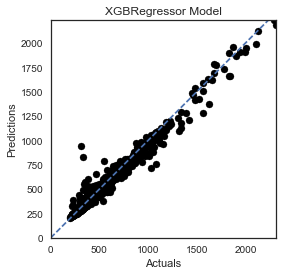

In [34]:
inputcolumns = ['Power Use Prior Year','Power Use Cum Avg', 'Power Use Prior Month', 'Power Use Rolling Month'] 

linsubmodel = LinearRegression()
linsubmodel.fit(train_features[inputcolumns],train_target)

train_features['Linear Prediction'] = linsubmodel.predict(train_features[inputcolumns])
test_features['Linear Prediction'] = linsubmodel.predict(test_features[inputcolumns])

xgbmodel  = fitAndPlot(train_features,test_features,train_target,test_target,xgboost.XGBRegressor,max_depth=6,n_estimators=1000,gamma=4,subsample=0.8)


In [35]:
train_features.columns

Index(['Zip', 'Month', 'Year', 'ZPOP', 'ZAREA', 'ZAREALAND', 'Nreturns', 'AGI',
       'SW', 'EIC', 'AWND', 'CLDD', 'HTDD', 'PRCP', 'TAVG',
       'Power Use Prior Year', 'Power Use Cum Avg', 'Power Use Prior Month',
       'Power Use Rolling Month', 'Linear Prediction'],
      dtype='object')

Power Use Model Feature ranking:
1. Land Area(5): 0.46% 
2. Average Temperature(14): 1.20% 
3. Population(3): 2.41% 
4. Total Area(4): 2.85% 
5. Year(2): 3.52% 
6. Precipitation(13): 3.59% 
7. Heating Degree Days(12): 3.81% 
8. Average Wind speed(10): 3.99% 
9. Salaries and Wages(8): 4.06% 
10. Month(1): 4.67% 
11. Earned Income Credit(9): 4.98% 
12. Adjusted Gross Income(7): 5.10% 
13. Number of Tax Returns(6): 5.21% 
14. Zip Code(0): 6.14% 
15. Cooling Degree Days(11): 6.27% 
16. Linear Prediction(19): 7.77% 
17. Power Use Cum Avg(16): 8.08% 
18. Power Use Rolling Month(18): 8.42% 
19. Power Use Prior Year(15): 8.70% 
20. Power Use Prior Month(17): 8.76% 


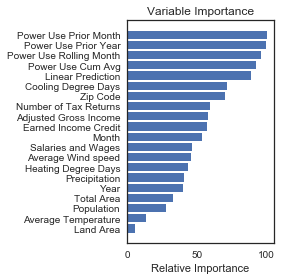

In [36]:
importances = xgbmodel.feature_importances_

indices = np.argsort(importances)[::1]
feature_names = np.array(['Zip Code', 'Month', 'Year', 'Population', 'Total Area', 'Land Area', 
        'Number of Tax Returns','Adjusted Gross Income', 'Salaries and Wages', 
        'Earned Income Credit', 'Average Wind speed', 'Cooling Degree Days', 'Heating Degree Days',
        'Precipitation', 'Average Temperature',
        'Power Use Prior Year', 'Power Use Cum Avg', 'Power Use Prior Month',
        'Power Use Rolling Month', 'Linear Prediction'])

# Print the feature ranking
print("Power Use Model Feature ranking:")
pos = np.arange(indices.shape[0]) + .5

for f in range(train_features.shape[1]):
    print("{0:d}. {1:s}({3:d}): {2:.2f}% ".format(f + 1, feature_names[indices[f]], importances[indices[f]]*100,indices[f]))

    

plt.figure(figsize=(4,4))
feature_importance = xgbmodel.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.savefig('../docs/PowerFeatureHist.png',dpi=300)

## Adaptive Model

Next up: an adaptive strategy where I retrain after every month in the last year.

In [39]:
total_results = pd.DataFrame()
end_date = ['2012-07-01','2012-08-01','2012-09-01','2012-10-01','2012-11-01','2013-01-01','2013-02-01','2013-03-01','2013-04-01','2013-05-01','2013-06-01']

for date in end_date:
    # Prepare training and testing datasets
    print ("Training for " + date)
    df_test = dfv9[dfv9['Date'] == date]
    test_features = df_test.drop(['Date'],axis=1).ix[:,1:]
    test_target = df_test.ix[:,0]

    df_train = dfv9[dfv9['Date'] < date]
    train_features = df_train.drop(['Date'],axis=1).ix[:,1:]
    train_target = df_train.ix[:,0]

    linModelInputColumns = ['Power Use Prior Year','Power Use Cum Avg','Power Use Prior Month', 'Power Use Rolling Month'] 
    linsubmodel = LinearRegression()
    linsubmodel.fit(train_features[linModelInputColumns],train_target)
    train_features['Linear Prediction'] = linsubmodel.predict(train_features[linModelInputColumns])
    test_features['Linear Prediction'] = linsubmodel.predict(test_features[linModelInputColumns])

    # Fit model and make predictions
    fitmodel = xgboost.XGBRegressor(max_depth=5,n_estimators=1000,gamma=4,subsample=0.8)
    # Timing
    start = time()
    # Fit the data
    fitmodel.fit(train_features,train_target)
    fit_time = time() - start
    start = time()
    # Get the predictions
    predictions = fitmodel.predict(test_features)
    predict_time = time() - start


    # Get the RMS values
    print("RMS Error: {0:.3f}".format( np.sqrt(np.mean((predictions - test_target) ** 2))))
    print("Fit Time: {} seconds".format(fit_time))
    print("Predict Time: {} seconds".format(predict_time))
    resultsdf = pd.DataFrame(df_test[['Date','Zip']])
    resultsdf['Predictions'] = predictions
    resultsdf['Actuals'] = test_target
    resultsdf['Error'] = predictions - test_target
    resultsdf['ABS Error'] = np.abs(resultsdf['Error'])
    
    total_results = total_results.append( resultsdf)

Training for 2012-07-01
RMS Error: 50.285
Fit Time: 7.475960969924927 seconds
Predict Time: 0.0050127506256103516 seconds
Training for 2012-08-01
RMS Error: 71.510
Fit Time: 7.762315511703491 seconds
Predict Time: 0.004010677337646484 seconds
Training for 2012-09-01
RMS Error: 38.580
Fit Time: 7.40871787071228 seconds
Predict Time: 0.0030078887939453125 seconds
Training for 2012-10-01
RMS Error: 41.559
Fit Time: 9.196282625198364 seconds
Predict Time: 0.004010200500488281 seconds
Training for 2012-11-01
RMS Error: 26.133
Fit Time: 8.65799880027771 seconds
Predict Time: 0.00400996208190918 seconds
Training for 2013-01-01
RMS Error: 26.546
Fit Time: 7.9051268100738525 seconds
Predict Time: 0.004010677337646484 seconds
Training for 2013-02-01
RMS Error: 42.482
Fit Time: 10.95061469078064 seconds
Predict Time: 0.004010915756225586 seconds
Training for 2013-03-01
RMS Error: 22.810
Fit Time: 8.861682653427124 seconds
Predict Time: 0.005012989044189453 seconds
Training for 2013-04-01
RMS Erro

Total Actuals: 687476
Total Predictions: 684322.3125
Total Absolute Prediction Error: 30,203 kWh (4.393403853576854%)
Total Net Prediction Error:  -3,153 kWh (-0.45873140807256363%)


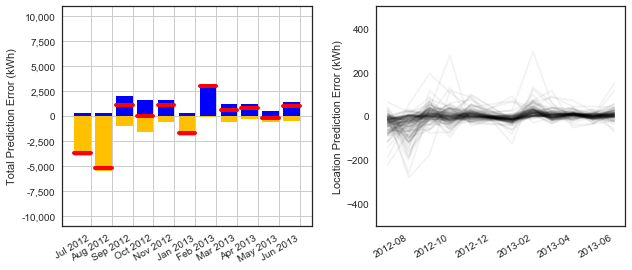

In [40]:
print("Total Actuals: {}".format(total_results['Actuals'].sum()))
print("Total Predictions: {}".format(total_results['Predictions'].sum()))
total_results.sort_values(['Zip','Date'],inplace=True)
groups = total_results.groupby('Zip')

dateTotals = total_results.groupby('Date')['Error'].sum().reset_index()

dateTotals['Total ABS Error'] = (total_results.groupby('Date')['ABS Error'].sum()).reset_index()['ABS Error']
totalerror = dateTotals['Total ABS Error'].sum()
#print("Total ABS Error: {:0.0f}".format(totalerror))


f, (ax2, ax1) = plt.subplots(1, 2,figsize=(9,4))
print('Total Absolute Prediction Error: {0:s} kWh ({1}%)'.format(format(int(totalerror), ','), totalerror/total_results['Actuals'].sum()*100))

ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax1.plot(group['Date'], group['Error'],color='black',alpha=0.05)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))
ax1.set_ylabel('Location Prediction Error (kWh)')
ax1.set_ylim(-500,500)



positiveErrors = total_results[total_results['Error'] >= 0]
negativeErrors = total_results[total_results['Error'] < 0]

dateTotals['Total Positive Error'] = positiveErrors.groupby('Date')['Error'].sum().reset_index()['Error']
dateTotals['Total Negative Error'] = negativeErrors.groupby('Date')['Error'].sum().reset_index()['Error']

dateTotals['positive'] = dateTotals['Error'] > 0
index = np.arange(0,len(dateTotals.index))
barwidth = 0.8

ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.bar(index,dateTotals['Total Positive Error'],barwidth, color='blue' )
ax2.bar(index,dateTotals['Total Negative Error'],barwidth, color='#ffc000' )
ax2.set_xticks(index+barwidth/2)
ax2.set_xticklabels(dateTotals['Date'].apply(lambda x: x.strftime("%b %Y")))
ax2.set_ylabel('Total Prediction Error (kWh)')
ax2.set_ylim(-11000,11000)

totalNeterror = dateTotals['Error'].sum()

for entry in range(len(dateTotals)):
    ax2.plot([index[entry]-barwidth/2,index[entry]+barwidth/2],[dateTotals['Error'][entry],dateTotals['Error'][entry]],color='red',linewidth=4)

#ax2.text(0,9500,'Net Prediction Error (HCF)',color='red',bbox=dict(facecolor='white', alpha=0.5))

print('Total Net Prediction Error:  {0:s} kWh ({1}%)'.format(format(int(totalNeterror),','),totalNeterror/total_results['Actuals'].sum()*100))

ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid()

f.tight_layout()
f.autofmt_xdate()
f.savefig('../docs/XGBModel_power.png', dpi=300)

The adaptive, predictive model does significantly better than the simple "last-year's number" model in predicting both the total power usage as well as the specific usage for each area.